<a href="https://colab.research.google.com/github/JSJeong-me/AI-Innovation-2024/blob/main/RL/6-6-agentchat_groupchat_finite_state_machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FSM - User can input speaker transition constraints

AutoGen offers conversable agents powered by LLM, tool, or human, which can be used to perform tasks collectively via automated chat. This framework allows tool use and human participation through multi-agent conversation.
Please find documentation about this feature [here](https://microsoft.github.io/autogen/docs/Use-Cases/agent_chat).

This notebook is about using graphs to define the transition paths amongst speakers.

Benefits
- This contribution fills the gap between the current modes of GroupChat Class (auto, manual, round_robin) and an expressive directed graph. See Motivation for more detailed discussion.


````{=mdx}
:::info Requirements
Install `autogen-agentchat`:
```bash
pip install autogen-agentchat~=0.2
```

For more information, please refer to the [installation guide](/docs/installation/).
:::
````

In [1]:
%%capture --no-stderr
%pip install autogen-agentchat[graph]~=0.2.11

In [2]:
import random  # noqa E402

import matplotlib.pyplot as plt  # noqa E402
import networkx as nx  # noqa E402

import autogen  # noqa E402
from autogen.agentchat.conversable_agent import ConversableAgent  # noqa E402
from autogen.agentchat.assistant_agent import AssistantAgent  # noqa E402
from autogen.agentchat.groupchat import GroupChat  # noqa E402
from autogen.graph_utils import visualize_speaker_transitions_dict  # noqa E402

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
print(autogen.__version__)

0.2.37


In [4]:
from google.colab import userdata
import openai
import os

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
openai.api_key  = os.environ["OPENAI_API_KEY"]

## Motivation


The current GroupChat class allows transitioning to any agent (with or without the decision of the LLM), some use cases might demand for more control over transition. A graph is a possible way to control the transition paths, where each node represents an agent and each directed edge represents possible transition paths. Let's illustrate the current transition paths for a GroupChat with five agents.

In [5]:
# gpt4_config = {
#     "cache_seed": False,  # change the cache_seed for different trials
#     "temperature": 0,
#     "config_list": [{"model": "gpt-4", "api_key": os.environ.get("OPENAI_API_KEY")}],
#     "timeout": 1200,
# }


In [6]:
import os

config_list_gpt4 = {
    "timeout": 600,
    "cache_seed": 44,  # change the seed for different trials
    "config_list":  [{"model": "gpt-4", "api_key": os.environ.get("OPENAI_API_KEY")}],
    "temperature": 0,
}

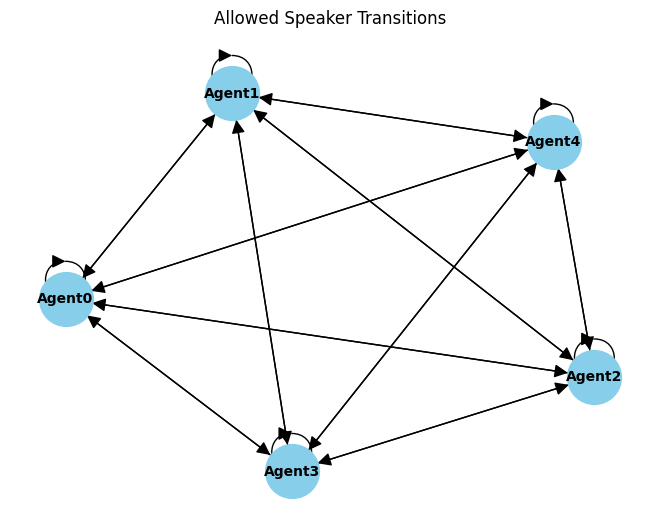

In [7]:
from autogen.agentchat.conversable_agent import ConversableAgent
import networkx as nx
import matplotlib.pyplot as plt

def visualize_speaker_transitions_dict(transitions_dict, agents):
  """
  Visualizes the speaker transitions using networkx and matplotlib.

  Args:
    transitions_dict: A dictionary mapping agents to their allowed transition targets.
    agents: A list of all agents.
  """
  G = nx.DiGraph()
  G.add_nodes_from([agent.name for agent in agents])
  for agent, allowed_transitions in transitions_dict.items():
    for target_agent in allowed_transitions:
      G.add_edge(agent.name, target_agent.name)

  pos = nx.spring_layout(G)
  nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=20)
  plt.title("Allowed Speaker Transitions")
  plt.show()


agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(5)]
allowed_speaker_transitions_dict = {agent: [other_agent for other_agent in agents] for agent in agents}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

In [8]:
# from autogen.agentchat.conversable_agent import ConversableAgent

# agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(5)]
# allowed_speaker_transitions_dict = {agent: [other_agent for other_agent in agents] for agent in agents}

# visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

### Possibly interesting transition paths
1. Hub and Spoke
2. Sequential Team Operations
3. Think aloud and debate

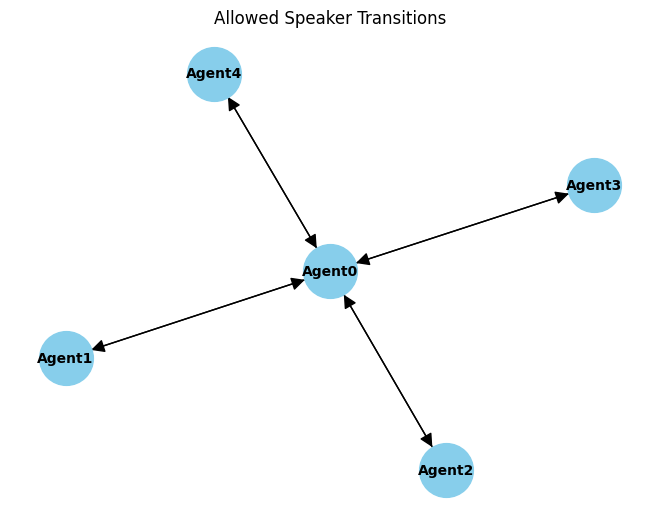

In [9]:
agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(5)]
allowed_speaker_transitions_dict = {
    agents[0]: [agents[1], agents[2], agents[3], agents[4]],
    agents[1]: [agents[0]],
    agents[2]: [agents[0]],
    agents[3]: [agents[0]],
    agents[4]: [agents[0]],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

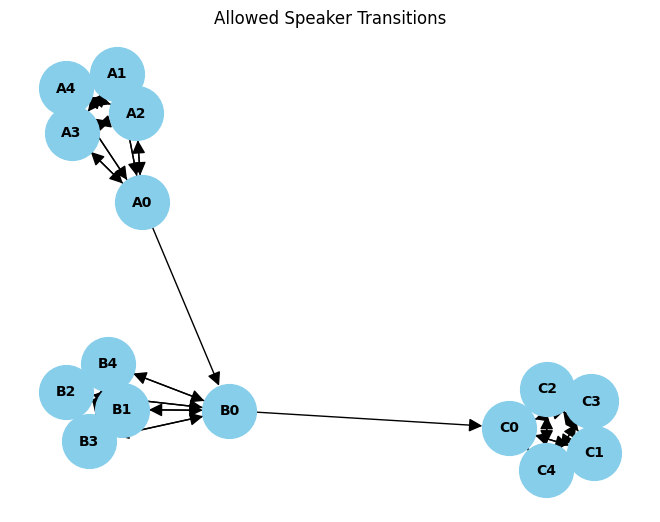

In [10]:
# Sequential Team Operations
# Create an empty directed graph

speaker_transitions_dict = {}
teams = ["A", "B", "C"]
team_size = 5


def get_agent_of_name(agents, name) -> ConversableAgent:
    for agent in agents:
        if agent.name == name:
            return agent


# Create a list of 15 agents 3 teams x 5 agents
agents = [ConversableAgent(name=f"{team}{i}", llm_config=False) for team in teams for i in range(team_size)]

# Loop through each team and add members and their connections
for team in teams:
    for i in range(team_size):
        member = f"{team}{i}"
        # Connect each member to other members of the same team
        speaker_transitions_dict[get_agent_of_name(agents, member)] = [
            get_agent_of_name(agents, name=f"{team}{j}") for j in range(team_size) if j != i
        ]

# Team leaders connection
print(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="C0"))

visualize_speaker_transitions_dict(speaker_transitions_dict, agents)

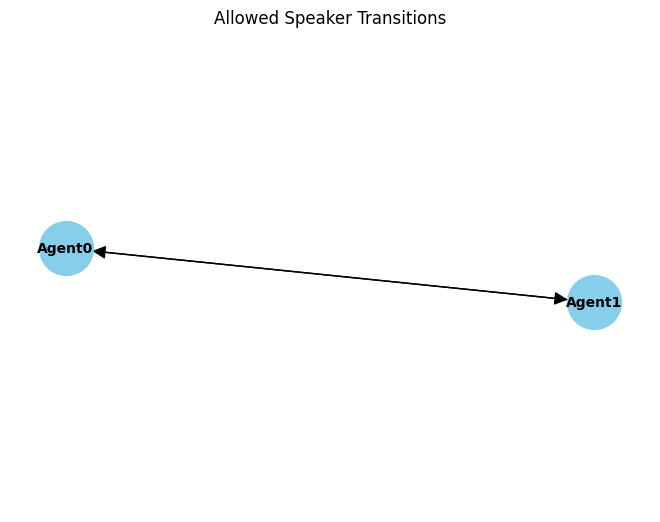

In [11]:
agents = [ConversableAgent(name=f"Agent{i}", llm_config=False) for i in range(2)]
allowed_speaker_transitions_dict = {
    agents[0]: [agents[0], agents[1]],
    agents[1]: [agents[0], agents[1]],
}

visualize_speaker_transitions_dict(allowed_speaker_transitions_dict, agents)

## Demonstration

`GroupChat` now takes in two optional arguments.
- allowed_or_disallowed_speaker_transitions: The keys are source agents, and the values are agents that the key agent can/can't transit to, depending on speaker_transitions_type. Default is None, which means all agents can transit to all other agents.
- speaker_transitions_type: whether the speaker_transitions_type is a dictionary containing lists of allowed agents or disallowed agents. "allowed" means the `allowed_or_disallowed_speaker_transitions` is a dictionary containing lists of allowed agents.

### Team Operations


In [12]:
import random
import networkx as nx
import matplotlib.pyplot as plt
from autogen import AssistantAgent  # Import AssistantAgent from autogen

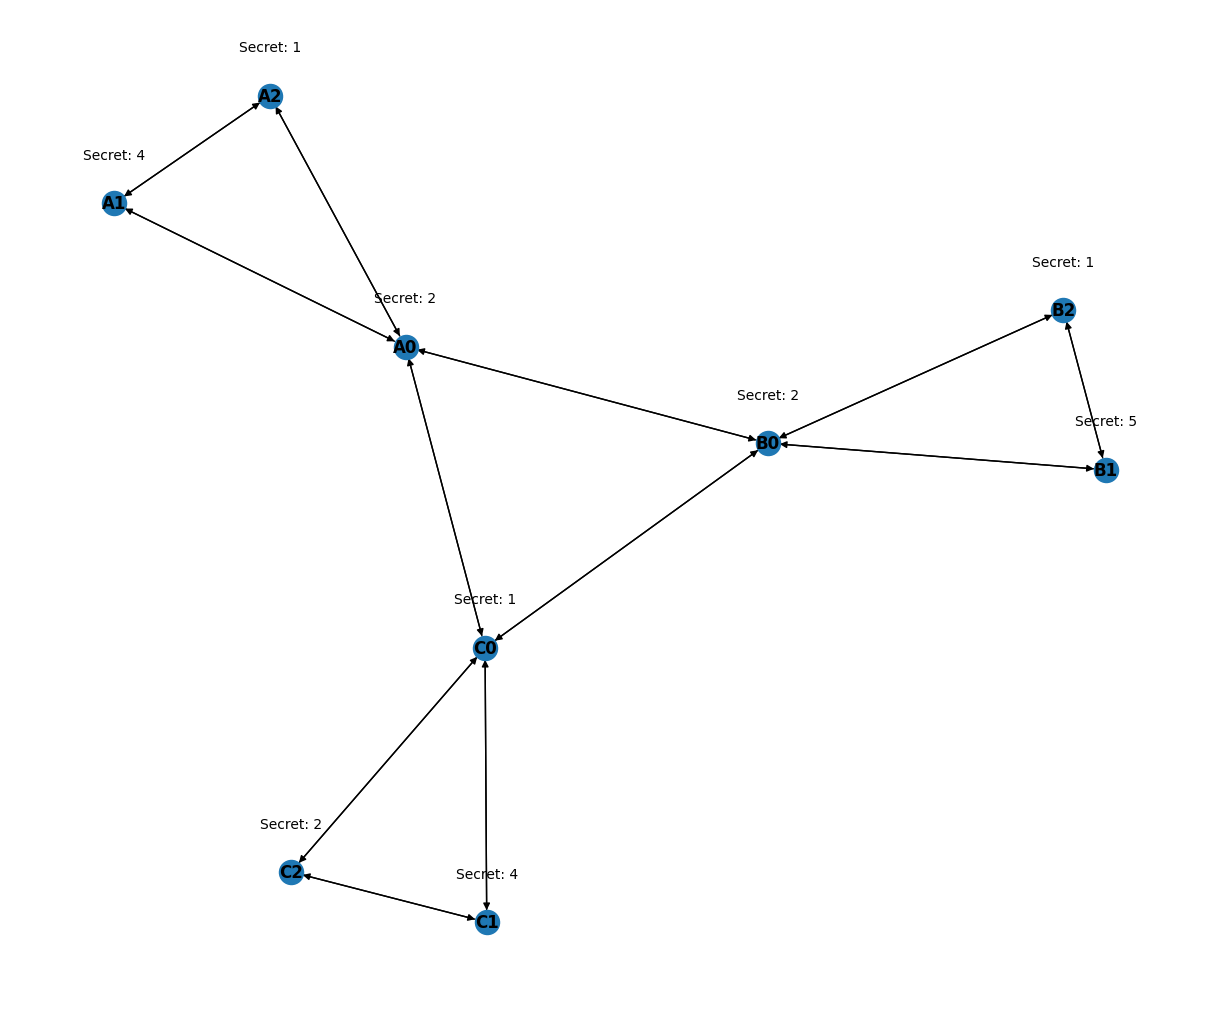

In [13]:
# Create an empty directed graph
agents = []
speaker_transitions_dict = {}
secret_values = {}

# Outer loop for prefixes 'A', 'B', 'C'
for prefix in ["A", "B", "C"]:
    # Add 3 nodes with each prefix to the graph using a for loop
    for i in range(3):
        node_id = f"{prefix}{i}"
        secret_value = random.randint(1, 5)  # Generate a random secret value
        secret_values[node_id] = secret_value

        # Create an AssistantAgent for each node (assuming AssistantAgent is a defined class)
        agents.append(
            AssistantAgent(
                name=node_id,
                system_message=f"""Your name is {node_id}.
                                          Do not respond as the speaker named in the NEXT tag if your name is not in the NEXT tag. Instead, suggest a relevant team leader to handle the mis-tag, with the NEXT: tag.

                                          You have {secret_value} chocolates.

                                          The list of players are [A0, A1, A2, B0, B1, B2, C0, C1, C2].

                                            Your first character of your name is your team, and your second character denotes that you are a team leader if it is 0.
                                            CONSTRAINTS: Team members can only talk within the team, whilst team leader can talk to team leaders of other teams but not team members of other teams.

                                            You can use NEXT: to suggest the next speaker. You have to respect the CONSTRAINTS, and can only suggest one player from the list of players, i.e., do not suggest A3 because A3 is not from the list of players.
                                            Team leaders must make sure that they know the sum of the individual chocolate count of all three players in their own team, i.e., A0 is responsible for team A only.

                                          Keep track of the player's tally using a JSON format so that others can check the total tally. Use
                                          A0:?, A1:?, A2:?,
                                          B0:?, B1:?, B2:?,
                                          C0:?, C1:?, C2:?

                                          If you are the team leader, you should aggregate your team's total chocolate count to cooperate.
                                          Once the team leader know their team's tally, they can suggest another team leader for them to find their team tally, because we need all three team tallys to succeed.
                                          Use NEXT: to suggest the next speaker, e.g., NEXT: A0.

                                          Once we have the total tally from all nine players, sum up all three teams' tally, then terminate the discussion using TERMINATE.

                                          """,
                llm_config=config_list_gpt4,
            )
        )
        speaker_transitions_dict[agents[-1]] = []

    # Add edges between nodes with the same prefix using a nested for loop
    for source_node in range(3):
        source_id = f"{prefix}{source_node}"
        for target_node in range(3):
            target_id = f"{prefix}{target_node}"
            if source_node != target_node:  # To avoid self-loops
                speaker_transitions_dict[get_agent_of_name(agents, source_id)].append(
                    get_agent_of_name(agents, name=target_id)
                )


# Adding edges between teams
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="B0"))
speaker_transitions_dict[get_agent_of_name(agents, "A0")].append(get_agent_of_name(agents, name="C0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="A0"))
speaker_transitions_dict[get_agent_of_name(agents, "B0")].append(get_agent_of_name(agents, name="C0"))
speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="A0"))
speaker_transitions_dict[get_agent_of_name(agents, "C0")].append(get_agent_of_name(agents, name="B0"))


# Visualization only
graph = nx.DiGraph()

# Add nodes
graph.add_nodes_from([agent.name for agent in agents])

# Add edges
for key, value in speaker_transitions_dict.items():
    for agent in value:
        graph.add_edge(key.name, agent.name)

# Visualize
# Draw the graph with secret values annotated
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(graph)  # positions for all nodes

# Draw nodes with their colors
nx.draw(graph, pos, with_labels=True, font_weight="bold")

# Annotate secret values
for node, (x, y) in pos.items():
    secret_value = secret_values[node]
    plt.text(x, y + 0.1, s=f"Secret: {secret_value}", horizontalalignment="center")

plt.show()

In [14]:
# Termination message detection
import autogen

def is_termination_msg(content) -> bool:
    have_content = content.get("content", None) is not None
    if have_content and "TERMINATE" in content["content"]:
        return True
    return False


# Terminates the conversation when TERMINATE is detected.
user_proxy = autogen.UserProxyAgent(
    name="User_proxy",
    system_message="Terminator admin.",
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
    human_input_mode="NEVER",
)

agents.append(user_proxy)

In [15]:
from autogen import AssistantAgent, GroupChat

group_chat = GroupChat(
    agents=agents,
    messages=[],
    max_round=20,
    allowed_or_disallowed_speaker_transitions=speaker_transitions_dict,
    speaker_transitions_type="allowed",
)


In [16]:


# Create the manager
manager = autogen.GroupChatManager(
    groupchat=group_chat,
    llm_config=config_list_gpt4,
    code_execution_config=False,
    is_termination_msg=is_termination_msg,
)


# Initiates the chat with Alice
agents[0].initiate_chat(
    manager,
    message="""
                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.
                        NEXT: A1""",
)

A0 (to chat_manager):


                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.
                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.
                        NEXT: A1

--------------------------------------------------------------------------------

Next speaker: A1

A1 (to chat_manager):

As A1, I have 4 chocolates. Now, we need to know how many chocolates A2 has. 

A0:?, A1:4, A2:?, 
B0:?, B1:?, B2:?, 
C0:?, C1:?, C2:?

NEXT: A2

--------------------------------------------------------------------------------

Next speaker: A2

A2 (to chat_manager):

As A2, I have 1 chocolate. Now, we need to know how many chocolates A0 has.

A0:?, A1:4, A2:1, 
B0:?, B1:?, B2:?, 
C0:?, C1:?, C2:?

NEXT: A0

--------------------------------------------------------------------------------

Next speaker: A0

A0 (to chat_manager):

As

ChatResult(chat_id=None, chat_history=[{'content': '\n                        There are 9 players in this game, split equally into Teams A, B, C. Therefore each team has 3 players, including the team leader.\n                        The task is to find out the sum of chocolate count from all nine players. I will now start with my team.\n                        NEXT: A1', 'role': 'assistant', 'name': 'A0'}, {'content': 'As A1, I have 4 chocolates. Now, we need to know how many chocolates A2 has. \n\nA0:?, A1:4, A2:?, \nB0:?, B1:?, B2:?, \nC0:?, C1:?, C2:?\n\nNEXT: A2', 'name': 'A1', 'role': 'user'}, {'content': 'As A2, I have 1 chocolate. Now, we need to know how many chocolates A0 has.\n\nA0:?, A1:4, A2:1, \nB0:?, B1:?, B2:?, \nC0:?, C1:?, C2:?\n\nNEXT: A0', 'name': 'A2', 'role': 'user'}, {'content': "As A0, I have 2 chocolates. Now, we know the total chocolate count for team A.\n\nA0:2, A1:4, A2:1, \nB0:?, B1:?, B2:?, \nC0:?, C1:?, C2:?\n\nTeam A's total chocolate count is 7. Now, we 